In [2]:
from functools import partial
import math
import torch
import torch.nn as nn
from torch.utils.data import WeightedRandomSampler
from torch.utils.data import DataLoader
import pytorch_lightning as pl
import os
import hydra
from omegaconf import DictConfig, open_dict
from datetime import date
from omegaconf import OmegaConf
from tqdm import tqdm
from hydra import initialize, initialize_config_module, initialize_config_dir, compose
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import itertools
from itertools import compress
import cv2
from einops import rearrange, repeat
from openslide import OpenSlide, PROPERTY_NAME_MPP_X

from classification.training.lightning import LightningClassifier
from classification.training.model import get_model
from classification.training.dataset import get_dataset
from classification.training.best_checkpoint import get_best_checkpoint
from classification.metrics import roc_auc_score, partial_roc_auc_score, screening_sens_at_spec
from array2gif import write_gif
from moviepy.editor import ImageSequenceClip

In [3]:
def create_dir_if_not_exists(dir):
	if not os.path.exists(dir):
		os.makedirs(dir)

In [4]:
checkpoint_path = '' # Insert path to best checkpoint


# Adapt these settings to match the settings used to train the model. For ease of use, leave the num_workers and batch_size at 1.
with initialize(config_path="../classification/config/"):
		cfg=compose(config_name="base_cfg.yaml", overrides=[
			"dataset=tcga_nsclc",
			f"meta.checkpoint_path={checkpoint_path}",
   			"optimizer.lr=6e-5",
      		"model.output_logits=1",
        	"model=cat_explainable",
         	"meta.prefix_name=tcga_nsclc_cat_explainable",
          	"epochs=50",
           	"meta.batch_size=1",
            "meta.cross_validation=True",
            "meta.num_workers=1",
            "meta.gpus=[0]",
            "meta.imbalance_handler=None",
            "optimizer.name=AdamW",
            "model.meta.depth=6",
            "model.meta.deep_supervision=True",
            "model.meta.feats_module.use_skip_connection=True",
           	"model.meta.use_dropout=True",
            "model.meta.p_do=0.9",
            "model.meta.cat_module.latent_dim=128",
            "model.meta.cat_module.cross_heads=3",
            "model.meta.cat_module.latent_dim=512",
            "model.meta.cat_module.self_per_cross_attn=2",
			])
		
  
train_dataset, validation_dataset, test_dataset, collate_fn = get_dataset(
cfg, fold=0)
train_dataloader = DataLoader(
		train_dataset, collate_fn=collate_fn, batch_size=cfg.meta.batch_size, shuffle=False, num_workers=cfg.meta.num_workers, drop_last=False, sampler=None)
val_dataloader = DataLoader(
		validation_dataset, collate_fn=collate_fn, batch_size=cfg.meta.batch_size, shuffle=False, num_workers=cfg.meta.num_workers, drop_last=False)
test_dataloader = DataLoader(
		test_dataset, collate_fn=collate_fn, batch_size=cfg.meta.batch_size, shuffle=False, num_workers=cfg.meta.num_workers, drop_last=False)

torch.cuda.is_available()

os.environ["CUDA_VISIBLE_DEVICES"]=f"{cfg.meta.gpus[0]}"
%env CUDA_VISIBLE_DEVICES=cfg.meta.gpus[0]
torch.cuda.set_device(cfg.meta.gpus[0])
device = f'cuda:{cfg.meta.gpus[0]}'

model = get_model(cfg)
trainable_classifier = LightningClassifier.load_from_checkpoint(checkpoint_path=cfg.meta.checkpoint_path, model=model, cfg=cfg);
trainable_classifier.eval();
trainable_classifier = trainable_classifier.to(device);

env: CUDA_VISIBLE_DEVICES=cfg.meta.gpus[0]
Note: The chosen CAT depths leads to a small number of latents in layer 3 (Number of latents: 8
Note: The chosen CAT depths leads to a small number of latents in layer 4 (Number of latents: 4
Note: The chosen CAT depths leads to a small number of latents in layer 5 (Number of latents: 2


In [5]:
from functools import wraps
import torch
from torch import nn

from classification.models.cat_explainable import Attention, CATModule


def find_modules(nn_module, type):
    return [module for module in nn_module.modules() if isinstance(module, type)]

class CrossAttentionRecorder(nn.Module):
    def __init__(self, model, device = None):
        super().__init__()
        self.model = model

        self.data = None
        self.recordings = []
        self.hooks = []
        self.hook_registered = False
        self.ejected = False
        self.device = device

    def _hook(self, _, input, output):
        self.recordings.append(output.clone().detach())

    def _register_hook(self):
        modules = []
        for layer in self.model.model.layers:
            modules.extend(find_modules(layer, Attention))
        for module in modules:
            handle = module.dropout.register_forward_hook(self._hook)
            self.hooks.append(handle)
        self.hook_registered = True

    def eject(self):
        self.ejected = True
        for hook in self.hooks:
            hook.remove()
        self.hooks.clear()
        return self.model

    def clear(self):
        self.recordings.clear()

    def record(self, attn):
        recording = attn.clone().detach()
        self.recordings.append(recording)

    def forward(self, input_):
        assert not self.ejected, 'recorder has been ejected, cannot be used anymore'
        self.clear()
        if not self.hook_registered:
            self._register_hook()

        pred = self.model.get_prediction(input_)

        # move all recordings to one device before stacking
        target_device = self.device if self.device is not None else input_[0].device
        recordings = tuple(map(lambda t: t.to(target_device), self.recordings))

		# Can't stack because of different size
        attns = recordings # torch.stack(recordings, dim = 1) if len(recordings) > 0 else None
        return pred, attns

In [6]:
index=3
batch = next(itertools.islice(iter(test_dataloader), index, None))
feats, ehr, label, label_names, coords, file_name = batch['feats'], batch['ehr'], batch['label'], batch['label_names'][0], batch['coords'], batch['file_name']
print(file_name)
print(label)

with torch.no_grad():
    feats = feats.to(device)
    ehr = ehr.to(device)
    label = label.to(device)
    
    prediction = trainable_classifier.get_prediction((feats, ehr))

    if isinstance(prediction, list):
        # Take the mean over all predictions
        prediction_prob = trainable_classifier._get_prediction_probability(torch.stack(prediction).mean(axis=0))
    else:
        prediction_prob = trainable_classifier._get_prediction_probability(prediction)


['TCGA-MN-A4N1-01Z-00-DX2.9B0852C4-16BF-4962-B86F-E2570E48A89E.h5']
tensor([[1.]])


In [7]:
v2 = CrossAttentionRecorder(trainable_classifier);
preds2, _attns = v2((feats, ehr));
v2.eject();

In [8]:
# Convert to attention per stage
# attn shape is B, H, N, D where H stands for the number of heads
attns = []
for i in range(0, len(_attns), cfg.model.meta.depth):
    attns_per_stage = []
    for attn in _attns[i: i+cfg.model.meta.depth]:
        attn_reshaped = rearrange(attn, '(b h) n d -> b h n d', b=cfg.meta.batch_size)
        attns_per_stage.append(attn_reshaped)
    attns.append(attns_per_stage)


### Only Cross-Attention

In [9]:
# Only Cross-Attention
BATCH_ELEM = 0
STAGE = 0
ca_attn = attns[STAGE][-(cfg.model.meta.cat_module.self_per_cross_attn + 1)][BATCH_ELEM].mean(dim=0)
attention_values_per_input_token = ca_attn[0, :]

In [10]:
# Attention Rollout
BATCH_ELEM = 0
STAGE = 4
ca_attn = attns[STAGE][-(cfg.model.meta.cat_module.self_per_cross_attn + 1)][BATCH_ELEM].mean(dim=0)
sa_attn_1 = attns[STAGE][-(cfg.model.meta.cat_module.self_per_cross_attn + 1) + 1][BATCH_ELEM].mean(dim=0)
sa_attn_2 = attns[STAGE][-(cfg.model.meta.cat_module.self_per_cross_attn + 1) + 2][BATCH_ELEM].mean(dim=0)

ca_attn = torch.matmul(ca_attn.T, torch.matmul(sa_attn_2.T, sa_attn_1.T)) 
print(ca_attn.shape)
attention_values_per_input_token = ca_attn.T[0, :]

torch.Size([5142, 9])


In [11]:
# Pool all stages
# Attention Rollout

BATCH_ELEM = 0
MEAN = True # Mean or Max over all stages
NORMALIZE = True
APPLY_LOG = True

attention_values_per_input_token_all_stages = []
for STAGE in range(cfg.model.meta.depth):
    ca_attn = attns[STAGE][-(cfg.model.meta.cat_module.self_per_cross_attn + 1)][BATCH_ELEM].mean(dim=0)
    sa_attn_1 = attns[STAGE][-(cfg.model.meta.cat_module.self_per_cross_attn + 1) + 1][BATCH_ELEM].mean(dim=0)
    sa_attn_2 = attns[STAGE][-(cfg.model.meta.cat_module.self_per_cross_attn + 1) + 2][BATCH_ELEM].mean(dim=0)

    ca_attn = torch.matmul(ca_attn.T, torch.matmul(sa_attn_2.T, sa_attn_1.T)) 
    print(ca_attn.shape)
    attention_values_per_input_token = ca_attn.T[0, :]
    
    # Normalize (maybe take out)
    if NORMALIZE:
        attention_values_per_input_token = (attention_values_per_input_token - attention_values_per_input_token.min()) / (attention_values_per_input_token.max() - attention_values_per_input_token.min()) * 255

    attention_values_per_input_token_all_stages.append(attention_values_per_input_token)

if MEAN:
    attention_values_per_input_token = torch.stack(attention_values_per_input_token_all_stages).mean(dim=0)
else:
    attention_values_per_input_token = torch.stack(attention_values_per_input_token_all_stages).max(dim=0)[0]

if APPLY_LOG:
    attention_values_per_input_token = torch.log(attention_values_per_input_token)
    attention_values_per_input_token = (attention_values_per_input_token - attention_values_per_input_token.min()) / (attention_values_per_input_token.max() - attention_values_per_input_token.min()) * 255

torch.Size([5142, 129])
torch.Size([5142, 65])
torch.Size([5142, 33])
torch.Size([5142, 17])
torch.Size([5142, 9])
torch.Size([5142, 5])


### Read in the original image and figure out where to map the heatmap coordinates

In [12]:
# Get Filename Hyperparameters
file_name_svs = '.'.join(file_name[BATCH_ELEM].split('.')[:-1]) + '.svs'
slide = OpenSlide(str(file_name_svs))

um_per_tile = 256
tile_size_px = um_per_tile/float(slide.properties[PROPERTY_NAME_MPP_X])
print("Tile size pixels: ", tile_size_px)

thumb_size = (np.array(slide.dimensions)/tile_size_px).astype(int)
print("Thumb Size: ", thumb_size)

Tile size pixels:  1013.0589631974674
Thumb Size:  [112  91]


In [13]:
thumb = slide.get_thumbnail(thumb_size)
thumb_grayscale = thumb.convert('L')
threshold = 224
mask = np.array(thumb_grayscale) >= np.array(thumb_grayscale).min() # Instead of thresholding, take all pixels

In [14]:
svs_coords = (np.flip(np.transpose(mask.nonzero()), 1) * tile_size_px).astype(int)

In [15]:
heatmap_values = np.zeros(len(svs_coords))
def find_index_in_array(array, coord):
    # Given an array of coordinates, find the index of the coordinate in the array
    find_coordinate = np.where((array == coord).all(axis=1)) 
    if len(find_coordinate[0]) > 0:
        return find_coordinate[0]
    else:
        return None

for idx, coord in enumerate(svs_coords):
    index = find_index_in_array(np.array(coords[BATCH_ELEM]), coord)
    if index is not None:
        heatmap_values[idx] = attention_values_per_input_token[index]

In [16]:
# Sort on coords (from top left to bottom right)
svs_sorted_indices = np.lexsort((svs_coords[:, 1], svs_coords[:, 0]))
svs_sorted_coords = svs_coords[svs_sorted_indices]
svs_sorted_heatmap_values = heatmap_values[svs_sorted_indices]

# Note: The coordinates are flipped, therefore we choose mask[1] first and mask[0] second and then transpose
heatmap = svs_sorted_heatmap_values.reshape((mask.shape[1], mask.shape[0])).T 


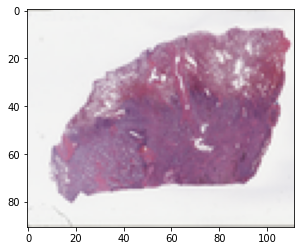

In [17]:
plt.imshow(thumb)

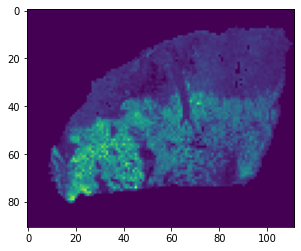

In [18]:
plt.imshow(heatmap)

(-0.5, 892.5, 727.5, -0.5)

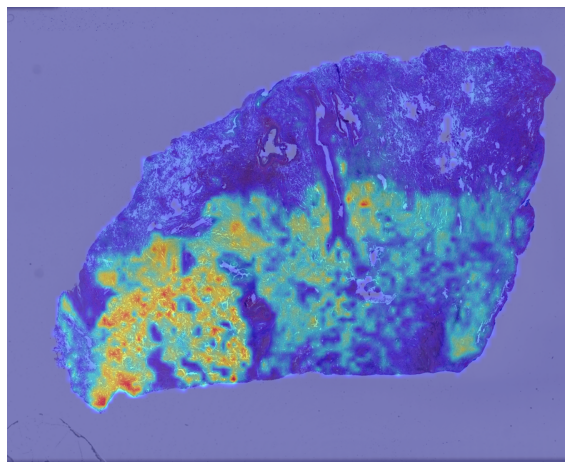

In [19]:
SCALE_FACTOR = 8
GRAYSCALE = False

# Normal Color
if GRAYSCALE:
	scaled_thumb = np.array(slide.get_thumbnail(thumb_size * SCALE_FACTOR).convert('L'))
	scaled_thumb = np.stack(3 * [scaled_thumb], 2)
else:
	scaled_thumb = np.array(slide.get_thumbnail(thumb_size * SCALE_FACTOR))

heatmap_cv2 = heatmap.copy()

target_shape = np.array(np.array(scaled_thumb).shape[:-1])

heatmap_cv2 = cv2.resize(heatmap_cv2, (target_shape[1], target_shape[0]))

heatmap_cv2 = (heatmap_cv2 - heatmap_cv2.min()) / (heatmap_cv2.max() - heatmap_cv2.min()) * 255
heatmap_cv2 = np.concatenate(3*[heatmap_cv2[:, :, None]], 2).astype(np.uint8)
heatmap_cv2[heatmap_cv2<0] = 0
heatmap_cv2 = cv2.applyColorMap(heatmap_cv2, cv2.COLORMAP_JET) #cv2.applyColorMap(opencv_img.astype(np.uint8), cv2.COLORMAP_JET)
heatmap_cv2 = cv2.cvtColor(heatmap_cv2, cv2.COLOR_BGR2RGB)
overlay_img = np.array(scaled_thumb).astype(np.uint8)

plt.figure(figsize=(10, 10))
plt.imshow(cv2.addWeighted(heatmap_cv2, 0.5, overlay_img, 0.5, 0))
plt.axis('off')

In [20]:
np.array(slide.get_thumbnail(thumb_size * SCALE_FACTOR).convert('L'))[:, :, None].shape

(728, 893, 1)

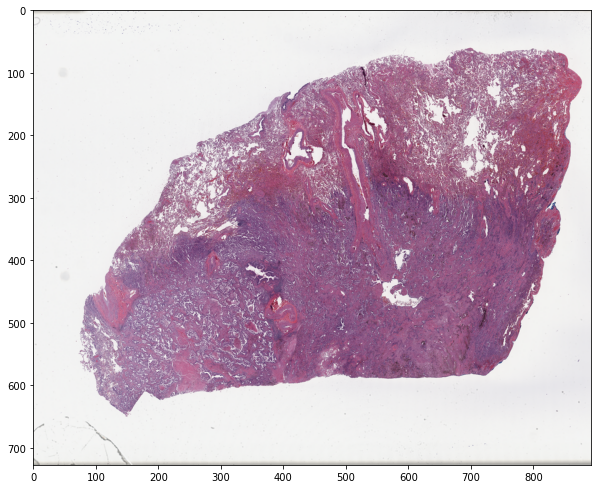

In [21]:
plt.figure(figsize=(10, 10))
plt.imshow(overlay_img)

(-0.5, 892.5, 727.5, -0.5)

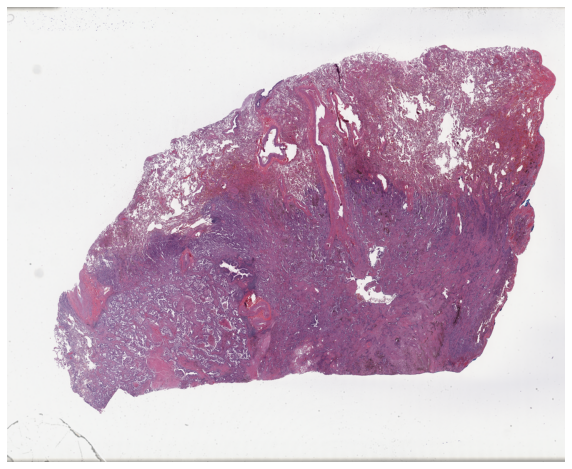

In [22]:
plt.figure(figsize=(10, 10))
plt.imshow(np.array(slide.get_thumbnail(thumb_size * SCALE_FACTOR)))
plt.axis('off')